<a href="https://colab.research.google.com/github/hackerinheels/dresser/blob/main/dresser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a notebook that builds a model to identify a traditional dresser against a contemporary or industrial style dresser.

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
print(tf.__version__)

2.6.0


In [3]:

from google.colab import files
uploaded = files.upload()


Saving data.zip to data.zip


In [98]:
import pathlib
dataset_url = "https://storage.googleapis.com/furndata/data.zip"

data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='data', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

unzip:  cannot find or open data.*, data.*.zip or data.*.ZIP.

No zipfiles found.


In [94]:
import glob
for name in data_dir.glob("*"):
    print(name)

/root/.keras/datasets/data/.DS_Store
/root/.keras/datasets/data/industrial
/root/.keras/datasets/data/contemporary
/root/.keras/datasets/data/traditional


In [95]:
print(len(list(data_dir.glob('*/*'))))


686


In [ ]:
#@title Colab Shell
%%html
<div id=term_demo></div>
<script src="https://code.jquery.com/jquery-latest.js"></script>
<script src="https://cdn.jsdelivr.net/npm/jquery.terminal/js/jquery.terminal.min.js"></script>
<link href="https://cdn.jsdelivr.net/npm/jquery.terminal/css/jquery.terminal.min.css" rel="stylesheet"/>
<script>
  $('#term_demo').terminal(async function(command) {
      if (command !== '') {
          try {
              let res = await google.colab.kernel.invokeFunction('shell', [command])
              let out = res.data['application/json'][0]
              this.echo(new String(out))
          } catch(e) {
              this.error(new String(e));
          }
      } else {
          this.echo('');
      }
  }, {
      greetings: 'Welcome to Colab Shell',
      name: 'colab_demo',
      height: 250,
      prompt: 'colab > '
  });

In [93]:
traditional = list(data_dir.glob('*/*'))


In [ ]:
roses = list(data_dir.glob('traditional/*'))
PIL.Image.open(str(roses[0]))

In [99]:
batch_size = 32
img_height = 180
img_width = 180

In [101]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 683 files belonging to 3 classes.
Using 547 files for training.


In [102]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 683 files belonging to 3 classes.
Using 136 files for validation.


In [103]:
class_names = train_ds.class_names
print(class_names)

['contemporary', 'industrial', 'traditional']


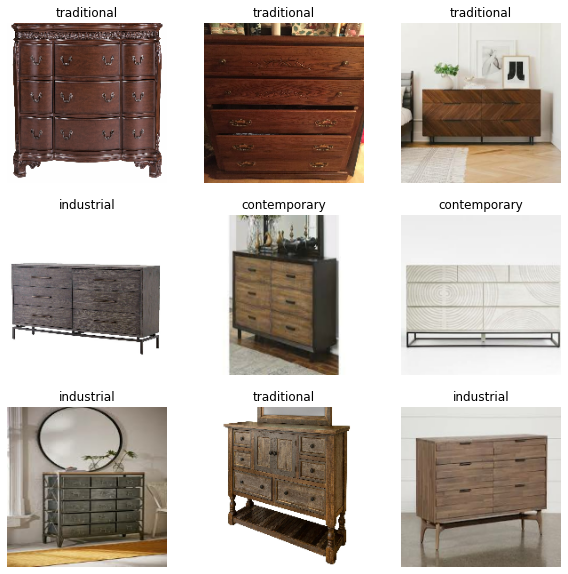

In [104]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [105]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [106]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9391503


In [107]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [120]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [124]:
num_classes = 3

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [125]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [126]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
18/18 [==============================] - 21s 1s/step - loss: 1.2267 - accuracy: 0.3638 - val_loss: 1.0942 - val_accuracy: 0.4044
Epoch 2/10
18/18 [==============================] - 20s 1s/step - loss: 1.0874 - accuracy: 0.4351 - val_loss: 1.0632 - val_accuracy: 0.4044
Epoch 3/10
18/18 [==============================] - 20s 1s/step - loss: 0.9887 - accuracy: 0.5210 - val_loss: 0.9127 - val_accuracy: 0.5588
Epoch 4/10
18/18 [==============================] - 20s 1s/step - loss: 0.8849 - accuracy: 0.5612 - val_loss: 0.8683 - val_accuracy: 0.5662
Epoch 5/10
18/18 [==============================] - 21s 1s/step - loss: 0.8324 - accuracy: 0.5996 - val_loss: 0.8577 - val_accuracy: 0.5735
Epoch 6/10
18/18 [==============================] - 21s 1s/step - loss: 0.8108 - accuracy: 0.5996 - val_loss: 0.8617 - val_accuracy: 0.5956
Epoch 7/10
18/18 [==============================] - 21s 1s/step - loss: 0.7654 - accuracy: 0.6417 - val_loss: 0.8393 - val_accuracy: 0.6176
Epoch 8/10
18/18 [==

In [127]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
18/18 [==============================] - 21s 1s/step - loss: 0.3939 - accuracy: 0.8537 - val_loss: 1.2273 - val_accuracy: 0.5735
Epoch 2/10
18/18 [==============================] - 21s 1s/step - loss: 0.4292 - accuracy: 0.8391 - val_loss: 0.9215 - val_accuracy: 0.5956
Epoch 3/10
18/18 [==============================] - 21s 1s/step - loss: 0.4124 - accuracy: 0.8117 - val_loss: 0.9854 - val_accuracy: 0.6691
Epoch 4/10
18/18 [==============================] - 21s 1s/step - loss: 0.2601 - accuracy: 0.8958 - val_loss: 1.1380 - val_accuracy: 0.6471
Epoch 5/10
18/18 [==============================] - 21s 1s/step - loss: 0.2229 - accuracy: 0.9269 - val_loss: 1.1509 - val_accuracy: 0.6544
Epoch 6/10
18/18 [==============================] - 21s 1s/step - loss: 0.1678 - accuracy: 0.9488 - val_loss: 1.8641 - val_accuracy: 0.5882
Epoch 7/10
18/18 [==============================] - 21s 1s/step - loss: 0.1864 - accuracy: 0.9287 - val_loss: 1.3557 - val_accuracy: 0.6471
Epoch 8/10
18/18 [==

In [128]:
checkpoint_path = "cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model with the new callback
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=1,
  callbacks=[cp_callback]
)
# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

18/18 [==============================] - 20s 1s/step - loss: 0.3687 - accuracy: 0.8592 - val_loss: 1.4006 - val_accuracy: 0.5662

Epoch 00001: saving model to cp.ckpt


In [129]:
# Loads the weights
model.load_weights(checkpoint_path)

# Re-evaluate the model
loss, acc = model.evaluate(test_images, test_labels, verbose=2)


NameError: ignored